In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
import numpy as np

Welcome to JupyROOT 6.15/01


In [2]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [3]:
def getLeptonData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [4]:
def getJetData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    scalar.append('quark_eta')
    scalar.append('quark_theta')
    scalar.append('quark_p')
    scalar.append('quark_pt')
    
    #hadron variables
    cols.append('jt')
    cols.append('z')
    cols.append('pid')
    cols.append('pt')
    cols.append('eta')
    cols.append('rap')
    cols.append('theta')
    cols.append('p')
    
    cols.append('in_jet_pt')
    cols.append('in_jet_dphi')
    cols.append('in_jet_eta')
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [5]:
##Selection on event variables
def applyEventCuts(df):
    print '################### ' 
    print 'Applying event selection'
    temp = df
    temp = applyCut(temp, 'y < 0.95 and y>0.01', '0.01 < y < 0.95')
    temp = applyCut(temp, 'Q2>100', 'Q2>100')
    
    #temp = applyCut(temp, 'y < 0.85 and y>0.1', '0.1 < y < 0.85')
    #temp = applyCut(temp, 'Q2>25', 'Q2>25')

    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    print '################### \n' 
    return temp

In [6]:
def applyJetCuts(df):
    print '################### ' 
    print 'Applying jet selection'
    temp = df
    temp = applyCut(temp, 'abs(pid)==211 or abs(pid)==111 or abs(pid)==321', 'Keep pions and charged kaons')
    temp = applyCut(temp, 'in_jet_pt>5', ' jet pT > 5 GeV') 
    temp = applyCut(temp, 'in_jet_dphi>2.74', ' e-jet dphi > 2.74') 
    temp.eval('in_jet_p = in_jet_pt*cosh(in_jet_eta)', inplace=True)
    print '################### \n' 


    return temp

## Get inclusive data

In [7]:
df_inclusive = getLeptonData(['CC_10_275.root'])
xsec = np.mean(df_inclusive['xsec'])
xsec = xsec*1e9
print 'xsection %2.2f [pb]' %(xsec)
accepted = df_inclusive.shape[0]
print 'accepted events' , accepted
to_cross_section = xsec/(1.0*accepted)
lumi = 100 # in units of fb-1. 
to_counts = to_cross_section*1000*lumi #1000 accounts to pass from pb to fb
##Apply selection
df_inclusive = applyEventCuts(df_inclusive)

##Total cross-section: 
integrated_rate    = 1000*lumi*xsec #multiply by 1000 and then 100 to get integrated yield for 100 fb-1
print 'Integrated rate %2.3f [M]' %(integrated_rate/1e6)




Processed CC_10_275.root in 0.4 seconds
xsection 14.27 [pb]
accepted events 25000
################### 
Applying event selection
0.01 < y < 0.95 23944  fraction kept: 95.8
Q2>100 23943  fraction kept: 100.0
################### 

Integrated rate 1.427 [M]


## Get jet/hadron data

In [8]:
df = getJetData(['CC_10_275.root'])
df = applyEventCuts(df)
df = applyJetCuts(df)



Processed CC_10_275.root in 1.3 seconds
################### 
Applying event selection
0.01 < y < 0.95 131606  fraction kept: 98.2
Q2>100 131601  fraction kept: 100.0
################### 

################### 
Applying jet selection
Keep pions and charged kaons 123142  fraction kept: 93.6
 jet pT > 5 GeV 123142  fraction kept: 100.0
 e-jet dphi > 2.74 117434  fraction kept: 95.4
################### 



## Plot all variables in the dataframe (after selection)

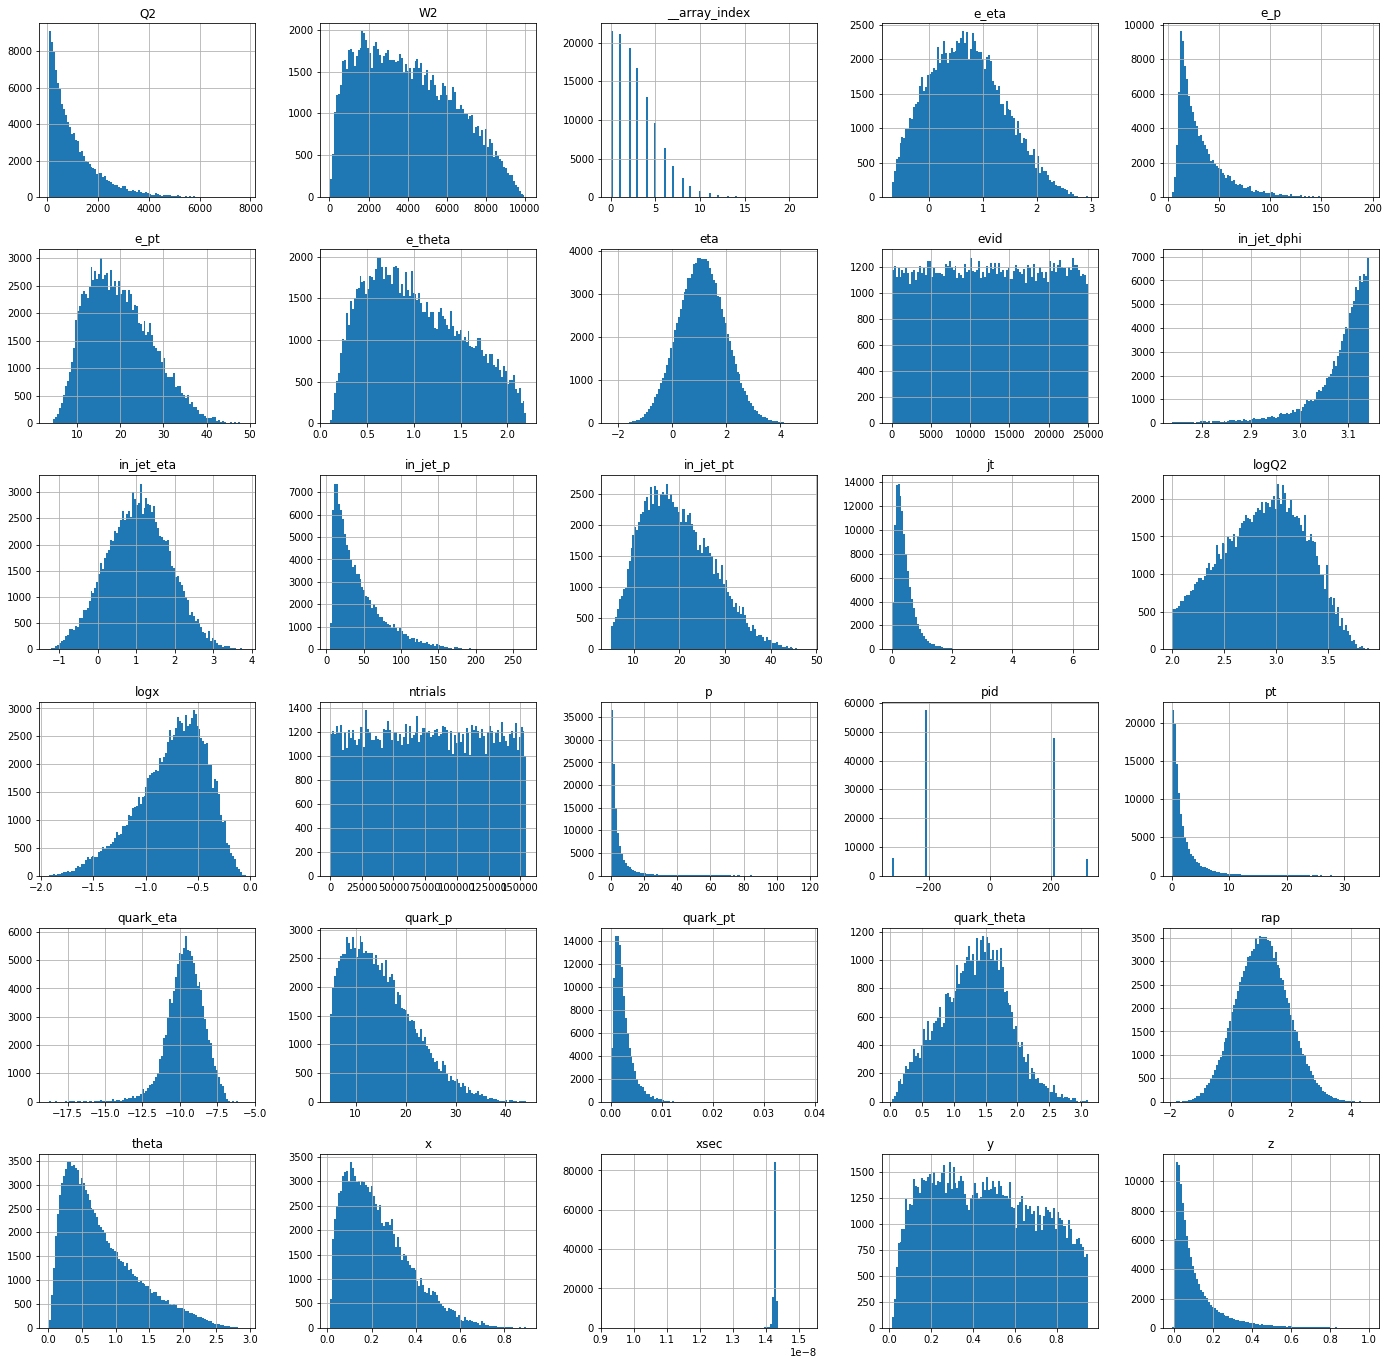

In [9]:
from matplotlib import rc
rc('text', usetex=False)
df.hist(figsize=(24,24),bins=100)
plt.show()

## Labels

In [10]:
jT_str = r'$j_T = |\vec{p}_{jet} \times \vec{p}_{hadron}| \left/ |\vec{p}_{jet}| \right GeV$'
z_str = r'$z = |\vec{p}_{jet} \cdot \vec{p}_{hadron}| \left/ |\vec{p}_{jet}|^2 \right.$'


## Dilution factors

In [11]:
dilution_factor = 0.7 # proton polarization x electron polarization 
efficiency = 0.8 #efficiency
penalty = 1.4 #sqrt(2) coming from separating statistically different azimuthal asymmetries
lumi = 100 # in units of fb-1. 100 is expected in a year running at 10e34. 
JES = 0.05 #jet energy scale uncertainty in percentage. 

## Fake asymmetries (should be updated with proper calculation)

In [12]:
max_A = 0.050
min_A = 0.001
slope = max_A-min_A
def fake_A(x,slope=max_A-min_A):
    return x*slope + min_A

In [13]:
def printSummary(df):
    print df['e_pt'].mean(), ' mean lepton pt'
    print df['y'].mean(), ' mean inelasticity'
    print df['in_jet_p'].mean(), ' mean jet p'
    print df['in_jet_pt'].mean(), ' mean jet pT'
    print df['in_jet_pt'].describe()

    print df['x'].mean(), ' mean x'
    print df['Q2'].mean(), ' mean Q2'
    print df['Q2'].describe()
    return

## Main result, integrated over x

number of inclusive events  939998.2316509181
21.375189  mean lepton pt
0.44894764  mean inelasticity
48.04686  mean jet p
21.04907  mean jet pT
count    86036.000000
mean        21.049070
std          6.299414
min          5.026142
25%         16.455591
50%         20.606213
75%         25.541346
max         41.672375
Name: in_jet_pt, dtype: float64
0.24861234  mean x
1204.7397  mean Q2
count    86036.000000
mean      1204.739746
std        887.748535
min        100.040077
25%        520.571396
50%        995.941772
75%       1654.814697
max       5215.566406
Name: Q2, dtype: float64
###########
positive pions
negative pions


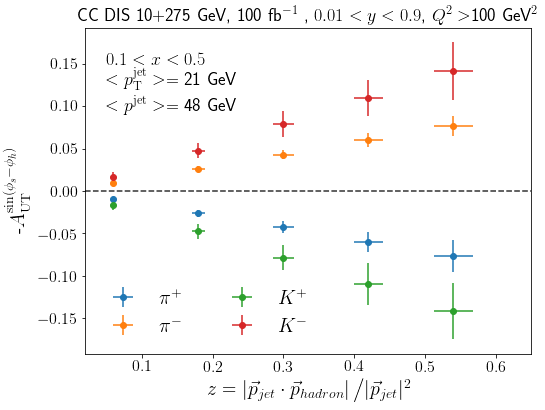

In [14]:
from matplotlib import rc
rc('text', usetex=True)
maxz = 0.6
binsz = 5
fig = plt.figure(figsize=(8,6))
query = 'x>%2.2f and x<=%2.2f '%(0.1,0.5)

print 'number of inclusive events ', df_inclusive.query(query).shape[0]*to_counts

for dataframe in [df]:
    df_cut = dataframe.query(query)
    
    meanQ2 = df_cut['Q2'].mean()
    mean_pt = df_cut['in_jet_pt'].mean()
    mean_p = df_cut['in_jet_p'].mean()
    printSummary(df_cut)
    
    print '###########'
    #positive pion
    print 'positive pions'
    y, x  = np.histogram(df_cut.query('pid==211')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=-fake_A(x,0.14) ,yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{+}$')
    
    #negative pion
    print 'negative pions'

    y, x  = np.histogram(df_cut.query('pid==-211')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency    
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=+fake_A(x,0.14) ,yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$\pi^{-}$')
    plt.axhline(y=0.0,color='black',linestyle='--',alpha=0.5)

    ##K+
    y, x  = np.histogram(df_cut.query('pid==321')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=-fake_A(x,0.26) , yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$K^{+}$')

    ##K-
    y, x  = np.histogram(df_cut.query('pid==-321')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    plt.errorbar(x,y=+fake_A(x,0.26) , yerr=erry,xerr=JES*x,fmt='o',ls='none',label='$K^{-}$')
    plt.axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
    
    
####
#plt.ylim([-0.061,0.061])
plt.xlim([0.02,0.65])

plt.text(0.05, 0.095, '$0.1<x<0.5$ \n $<p_{\mathrm{T}}^{\mathrm{jet}}>$' +'= %2.0f GeV \n $<p^{\mathrm{jet}}>$= %2.0f GeV'%(mean_pt,mean_p), fontsize=18)
plt.title('CC DIS 10+275 GeV, 100 fb$^{-1}$ , $0.01<y<0.9$, $Q^{2}>$100 GeV$^{2}$', fontsize=18)
#plt.text(0.05, 0.025, '$<p_{\mathrm{T}}^{\mathrm{jet}}>$=%2.0f GeV'%df_cut['in_jet_pt'].mean() + ' , $5\%$ JES error', fontsize=17)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='lower left', fontsize=20,frameon=False,ncol=2)
plt.ylabel('-$A_{\mathrm{UT}}^{\sin(\phi_s-\phi_h)}$',fontsize=20)
plt.xlabel(z_str,fontsize=20)
plt.savefig('CC_AUT_main_comparison.png', bbox_inches='tight')
plt.savefig('CC_AUT_main_comparison.pdf', bbox_inches='tight')

0 0
x>0.10 and x<=0.20 and jt<1.0 
17.117487  mean lepton pt
0.47029218  mean inelasticity
30.07875  mean jet p
16.803205  mean jet pT
count    32082.000000
mean        16.803205
std          3.891992
min          5.051076
25%         14.313963
50%         17.027622
75%         19.571859
max         36.274418
Name: in_jet_pt, dtype: float64
0.14857061  mean x
766.4686  mean Q2
count    32082.000000
mean       766.468628
std        441.954468
min        100.040077
25%        391.121155
50%        714.089661
75%       1066.946533
max       2070.154053
Name: Q2, dtype: float64
#############################################################
0 1
x>0.20 and x<=0.50 and jt<1.0 
24.066372  mean lepton pt
0.43477374  mean inelasticity
59.317223  mean jet p
23.679285  mean jet pT
count    48266.000000
mean        23.679285
std          6.092418
min          5.026142
25%         19.638842
50%         24.025284
75%         27.975102
max         41.672375
Name: in_jet_pt, dtype: float64
0.31371185  m

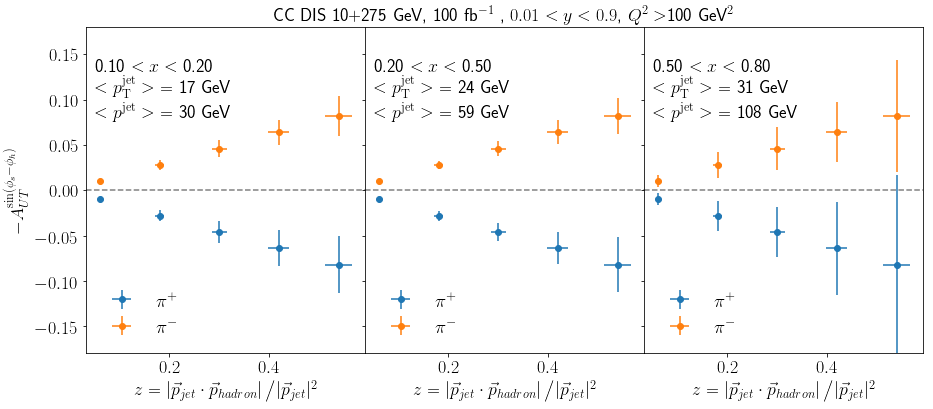

In [29]:
fig, axs = plt.subplots(1, 3,sharex=True,sharey=True, figsize=(15,6), gridspec_kw={'wspace':0, 'hspace':0.0})
Edges = [0.1, 0.2,0.5,0.8]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]

maxz = 0.6
axs[1].set_title('CC DIS 10+275 GeV, 100 fb$^{-1}$ , $0.01<y<0.9$, $Q^{2}>$100 GeV$^{2}$', fontsize=18)


for j, ibin in enumerate(bins):
    if j<3:
        i = 0
    else:
        i= 1
        j= j%3
    print i, j
    query = 'x>%2.2f and x<=%2.2f and jt<1.0 '%(ibin[0],ibin[1])
    print query
    df_cut = df.query(query)
    printSummary(df_cut)

    meanQ2 = df_cut['Q2'].mean()
    mean_pt = df_cut['in_jet_pt'].mean()
    mean_p = df_cut['in_jet_p'].mean()
    
    print '#############################################################'
    #pi+
    y, x  = np.histogram(df_cut.query('pid==211')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[j].errorbar(x,y=-fake_A(x,0.15) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{+}$')
    
    #pi-
    y, x  = np.histogram(df_cut.query('pid==-211')['z'],bins=binsz,range=(0,maxz))
    x = (x[1:]+x[:-1])/2
    y = y*to_counts
    y = y*efficiency
    erry = penalty*1/(dilution_factor*np.sqrt(y))
    axs[j].errorbar(x,y=fake_A(x,0.15) , yerr=erry,xerr=JES*x, fmt='o',ls='none',label='$\pi^{-}$')
    axs[j].tick_params('both',labelsize=18)
    
    axs[j].legend(loc='lower left',fontsize=19,frameon=False)
    axs[j].xaxis.set_label_text(z_str,fontsize=18)
    #axs[i,j].set_title('%2.2f $<x<$ %2.2f, $<Q^{2}>$=%2.0f GeV$^{2}$'%(ibin[0],ibin[1],meanQ2), fontsize=14)    
    axs[j].axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
    axs[j].text(0.05, 0.08, '%2.2f $<x<$ %2.2f\n $<p_{\mathrm{T}}^{\mathrm{jet}}>$ = %2.0f GeV \n $<p^{\mathrm{jet}}>$ = %2.0f GeV'%(ibin[0],ibin[1],df_cut['in_jet_pt'].mean(),df_cut['in_jet_p'].mean()), fontsize=18)
    #axs[i,j].text(0.05, 0.04, '$<p^{\mathrm{jet}}>$ = %2.0f GeV'%df_cut['in_jet_p'].mean(), fontsize=14)

    plt.ylim([-0.18,0.18])
    #plt.yticks(fontsize=28)
    #plt.xticks(fontsize=28)
    
axs[0].yaxis.set_label_text('$-A_{UT}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
#axs[1].yaxis.set_label_text('$A_{UT}^{\sin(\phi_s-\phi_h)}$',fontsize=18)
plt.savefig('CC_AUT_projections_xbins.png', bbox_inches='tight')
plt.savefig('CC_AUT_projections_xbins.pdf', bbox_inches='tight')